In [3]:
#This was taken from https://colab.research.google.com/github/jeffheaton/t81_558_deep_learning/blob/master/t81_558_class_12_01_ai_gym.ipynb#scrollTo=XDKGJ9A3O8fT
#Was struggling to set up the gym environment beforehand

# HIDE OUTPUT
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
!apt-get update > /dev/null 2>&1
!apt-get install cmake > /dev/null 2>&1
!pip install --upgrade setuptools 2>&1
!pip install ez_setup > /dev/null 2>&1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.2 MB 31.1 MB/s 
  Attempting uninstall: setuptools
    Found existing installation: setuptools 57.4.0
    Uninstalling setuptools-57.4.0:
      Successfully uninstalled setuptools-57.4.0


In [1]:
#Upgrade gym to latest version for better video recording
!pip uninstall gym
!pip install gym
!pip install gym[box2d]
!pip show gym

Found existing installation: gym 0.17.3
Uninstalling gym-0.17.3:
  Would remove:
    /usr/local/lib/python3.7/dist-packages/gym-0.17.3.dist-info/*
    /usr/local/lib/python3.7/dist-packages/gym/*
Proceed (y/n)? y
  Successfully uninstalled gym-0.17.3
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 732 kB 28.5 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for gym: filename=gym-0.25.1-py3-none-any.whl size=849027 sha256=7d917898a94e2801b9175fe0e271bf1a80aef1c8fac7443f36c4063a66ff5150
  Stored in directory: /root/.cache/pip/wheels/0e/2d/04/f964345f96b1348723057d60011be1e48885a027c9c5b92210
Successfully built gym
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.1 MB 31.8 MB/s 
     |███████████████████████████

In [121]:
#set up initial dependencies and display method show_video from aforementioned colab notebook
import gym
import glob
import io
import base64
from IPython.display import HTML
from pyvirtualdisplay import Display
from IPython import display as ipythondisplay
import random
import numpy as np
from collections import deque

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras import backend as K
from keras.layers.advanced_activations import PReLU

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn

display = Display(visible=0, size=(1400, 900))
display.start()

#The below method taken from https://colab.research.google.com/github/jeffheaton/t81_558_deep_learning/blob/master/t81_558_class_12_01_ai_gym.ipynb#scrollTo=XDKGJ9A3O8fT
# with a modification to be able to call a specific video by index"

def show_video(folder, video_id):
    mp4list = glob.glob(folder + '/*.mp4')
    if len(mp4list) > 0:
        mp4 = mp4list[video_id]
        video = io.open(mp4, 'r+b').read()
        encoded = base64.b64encode(video)
        ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
    else:
        print("Could not find video")

/usr/local/lib/python3.7/dist-packages/seaborn/rcmod.py:82: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":
/usr/local/lib/python3.7/dist-packages/setuptools/_distutils/version.py:346: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


In [4]:
#Demonstration of the observation and action space

env = gym.make("LunarLander-v2", new_step_api = True)

obs = env.reset()
print("First obs", obs)
action = env.action_space.sample()
obs, reward, done, info, _ = env.step(action)
print("Second obs", obs)
print("reward", reward)
print("Done", done)


print("Action Space: ", env.action_space)
print("State Space: ", env.observation_space.shape)


First obs [ 0.00475636  1.4105724   0.4817523  -0.01545404 -0.00550465 -0.10912408
  0.          0.        ]
Second obs [ 0.00951281  1.4096477   0.48110119 -0.04112822 -0.01089694 -0.10785519
  0.          0.        ]
reward -0.534753068666248
Done False
Action Space:  Discrete(4)
State Space:  (8,)


In [111]:
#Set up universal parameters

SEED = 42
tf.random.set_seed(SEED)

env = gym.make("LunarLander-v2")
env = gym.wrappers.RecordVideo(env, 'video4', episode_trigger = lambda x: x % 100 == 0)
env.seed(SEED)
np.random.seed(SEED)


#Was designed for 2000 episodes. This was however, too time intensive so I was forced to cut it short.
train_episodes = 2000

/usr/local/lib/python3.7/dist-packages/gym/core.py:330: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  "Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future."
/usr/local/lib/python3.7/dist-packages/gym/wrappers/step_api_compatibility.py:40: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  "Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future."
/usr/local/lib/python3.7/dist-packages/gym

In [112]:
#set up neural network according to shape of observation and action spaces
#the output layer will predict a q-value for each action
#Action reference: [do nothing, left engine, main engine, right engine]
def agent(state_shape, action_shape):

  init = tf.keras.initializers.HeUniform()
  model = models.Sequential()
  model.add(layers.Dense(32, activation='relu', input_shape=state_shape, kernel_initializer=init))
  model.add(layers.Dense(16, activation='relu', kernel_initializer=init))
  model.add(layers.Dense(action_shape, activation='linear', kernel_initializer=init))
  model.compile(loss=tf.keras.losses.Huber(), optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=['accuracy'])
  return model

In [107]:
def train(env, step_record, model, target_model, done, training_steps):
  learning_rate = 0.7 #stays constant -- favors new information
  discount_factor = 0.5 #stays constant -- favors immediate reward
  batch_size = 256

  batch = random.sample(step_record, batch_size) #select a random batch from the step info packs observed so far over all iterations
  current_states = np.array([step[0] for step in batch]) #extract the state from each step info pack
  current_qs_list = model.predict(current_states) #predict a q_value based on each state/action
  new_current_states = np.array([step[3] for step in batch]) #extract the follow on state from each step info pack
  future_qs_list = target_model.predict(new_current_states) #predict what the q value will be from the next state

  inputs = []
  outputs = []
  for index, (obs, action, reward, new_obs, done, episode_steps) in enumerate(batch): #determine value of q-values
    if not done:
      max_future_q = reward + discount_factor * np.max(future_qs_list[index])
    else:
      max_future_q = reward
  
    #bellman update
    current_qs = current_qs_list[index]
    current_qs[action] = (1 - learning_rate) * current_qs[action] + learning_rate * max_future_q

    inputs.append(obs)
    outputs.append(current_qs)

  model.fit(np.array(inputs), np.array(outputs), batch_size=batch_size, verbose=0, shuffle=True) #retrain the model


In [ ]:
#set up epsilon parameters. We will start with random exploration
epsilon = 1.0

step_record = deque(maxlen=50000) #this will contain the record of past observations for model training

model = agent(env.observation_space.shape, env.action_space.n) #initialize frequent model
target_model = agent(env.observation_space.shape, env.action_space.n) #initialize target model
target_model.set_weights(model.get_weights()) #copy weights into target model

total_rewards = 0
training_steps = 0
i_benchmark = 0
reward_history = []


for i in range(train_episodes): #iterate though all training episodes
    training_rewards = 0
    obs = env.reset()
    done = False
    episode_steps = 0
    while not done:
        training_steps += 1
        episode_steps += 1
        random_action = random.random()
        if random_action < epsilon: #explore
            action = env.action_space.sample()
        else: #choose based on policy
            observation = obs.reshape([1, obs.shape[0]])
            pred_action = model.predict(observation).flatten()
            action = np.argmax(pred_action) #select the most promising-looking action based on model
        new_obs, reward, done, _ = env.step(action)
        step_record.append([obs, action, reward, new_obs, done, episode_steps]) #add observation to record for training

        if (training_steps % 4 == 0 or done) and len(step_record) > 1000: #once enough observations are collected, train every four steps
            train(env, step_record, model, target_model, done, training_steps)
        
        obs = new_obs
        training_rewards += reward
        
        if done: #when done, update the target model if sufficient time (100 steps) has elapsed
            if training_steps >= 100:
                print("Updating target model")
                target_model.set_weights(model.get_weights())
                training_steps = 0
            print("Episode %d done in %d steps, total reward %.2f" % (i, episode_steps, training_rewards)) #status report
            total_rewards += training_rewards
            reward_history.append(training_rewards) #for future plotting
            if i%10 == 0: #progress reportsd
              average_rewards = total_rewards / 10
              print("Average reward over last 10 events: ", average_rewards)
              total_rewards = 0
            break

    i_benchmark += 1 #decrement epsilon by 0.1 every 100 episodes
    if i_benchmark == 100:
      epsilon = (epsilon - 0.1)
      i_benchmark = 0
    #print("Epsilon: ", epsilon)

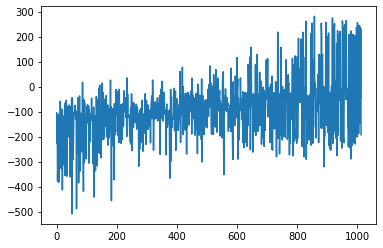

In [125]:
xvals = np.arange(1013)
plt.plot(xvals, reward_history);

In [ ]:
#Run 100 test iterations using the trained model; will store videos in "videotest" folder

testenv = gym.make("LunarLander-v2")
testenv = gym.wrappers.RecordVideo(testenv, 'videotest', episode_trigger = lambda x: x % 1 == 0)

total_rewards = 0
training_steps = 0
i_benchmark = 0
test_history = []

for i in range(100):
    training_rewards = 0
    obs = testenv.reset()
    done = False
    episode_steps = 0
    while not done:
        episode_steps += 1
        observation = obs.reshape([1, obs.shape[0]])
        pred_action = target_model.predict(observation).flatten()
        action = np.argmax(pred_action)
        new_obs, reward, done, _ = testenv.step(action)
        obs = new_obs
        training_rewards += reward
        if done:
            total_rewards += training_rewards
            test_history.append(training_rewards)
            break

env.close()

19.520462951107085 178.93730505751935 289.2638693402678


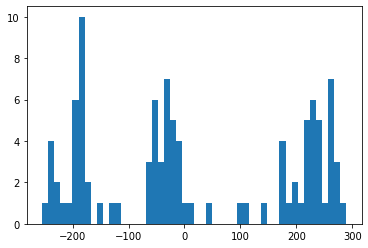

In [128]:
plt.hist(test_history,bins=50);
print(np.mean(test_history), np.std(test_history), max(test_history))

In [129]:
show_video('videotest', 20)

/usr/local/lib/python3.7/dist-packages/gym/core.py:330: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  "Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future."
/usr/local/lib/python3.7/dist-packages/gym/wrappers/step_api_compatibility.py:40: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  "Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future."


-199.90630528721664 119.79017334128199 39.32448680971413


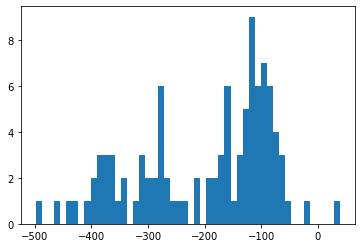

In [131]:
#Run 100 random iterations and plot

randenv = gym.make("LunarLander-v2")

total_rewards = 0
training_steps = 0
i_benchmark = 0
randreward_history = []


for i in range(100):
    training_rewards = 0
    obs = randenv.reset()
    done = False
    episode_steps = 0
    while not done:
        episode_steps += 1
        action = randenv.action_space.sample()
        new_obs, reward, done, _ = randenv.step(action)
        obs = new_obs
        training_rewards += reward

        if done:
            total_rewards += training_rewards
            randreward_history.append(training_rewards)
            break

plt.hist(randreward_history,bins=50);
print(np.mean(randreward_history), np.std(randreward_history), max(randreward_history))

In [132]:
test_history

[-254.46738588200157,
 -187.58130529032894,
 214.65816446989248,
 -229.84694813037234,
 -239.39849670132926,
 -64.4360732908146,
 -22.919010594641293,
 238.29399089543833,
 -183.3062405744568,
 -41.72717950245344,
 -64.7995978330936,
 -29.557070023766173,
 -48.20055780466399,
 -199.19791277769752,
 -184.27929220798245,
 -31.90317481004567,
 251.86106173211132,
 -37.29379567856277,
 -7.036032197823246,
 260.4522498238894,
 -178.96987978274558,
 259.3494064101596,
 -198.41330761031148,
 -21.65279542470938,
 -33.38906258662212,
 226.361937418355,
 227.5408564509259,
 142.50124499083185,
 179.58156732053237,
 245.24003795780732,
 -53.255677966395496,
 -21.886993453613115,
 -25.88351664745491,
 289.2638693402678,
 -183.75825372142486,
 234.7128314921214,
 -54.137404672440155,
 -175.73046405016987,
 228.9908944755687,
 -38.55498307169137,
 -29.399963762714776,
 179.48304947500102,
 -180.00907378142605,
 -237.55192076911553,
 -182.84463542223824,
 232.73720251708988,
 185.06220074139804,
 -19